In [1]:
import numpy as np
from rss.forge_client import plot, process, rssFORGEFromS3

# The FORGE RSS Client
To connect to the data, you can create a rss client, shown here:

In [2]:
client = rssFORGEFromS3('s3://forge-das-rss/das.zarr')

Establishing Connection, may take a minute ......


If you cannot connect to this client for reasons of permissions, then raise an issue and we will 
try to resolve it. 

## Overview

The FORGE DAS data consistes of 71,880 segy files. We've exported *some of these to rss format, these files are indexed by the order they appear in the get_all_silixa.sh script, which isn't the most scientific way of doing things, but they are at least laid out in chronological order. 

The rss client views each of the 71,880 as a 2-d array of data (we reuse the term "line" borrowing from work on seismic data, but this is actually a recording over time for every channel in the array). To access the data we need to have an "index" for the recording we're interested in.

To find the recordings with know microseismic events, the client stores and array "sample events":

In [3]:
client.sample_events[::20,:]

array([[13313, 38298],
       [28382, 38377],
       [ 3939, 38464],
       [17060, 38932],
       [ 8749, 43584],
       [18680, 43663]])

The first column, is the "time" the event was seen in the recording (in samples), the second column is the index of the recording in the larger 71,880 file dataset.

The client also stores the recievers "measured depth" in feet (the monitor well is vertical). And the time (in seconds) of each sample from the start of the recording. 

In [4]:
client.depth[::20]

array([-637.228, -571.003, -504.778, -438.552, -372.327, -306.102,
       -239.877, -173.651, -107.426,  -41.201,   25.024,   91.25 ,
        157.475,  223.7  ,  289.925,  356.151,  422.376,  488.601,
        554.826,  621.052,  687.277,  753.502,  819.727,  885.953,
        952.178, 1018.403, 1084.628, 1150.854, 1217.079, 1283.304,
       1349.529, 1415.755, 1481.98 , 1548.205, 1614.43 , 1680.656,
       1746.881, 1813.106, 1879.331, 1945.557, 2011.782, 2078.007,
       2144.232, 2210.458, 2276.683, 2342.908, 2409.133, 2475.359,
       2541.584, 2607.809, 2674.034, 2740.26 , 2806.485, 2872.71 ,
       2938.935, 3005.161, 3071.386, 3137.611, 3203.836, 3270.062,
       3336.287, 3402.512, 3468.737, 3534.963])

In [5]:
client.time_seconds[::20]

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 1.497e+01, 1.498e+01,
       1.499e+01])

To locate 34th known event in the sample":

In [6]:
ievent = 34
time_slice, event_34 = client.sample_events[ievent,:]
print (f'event {ievent} appears on recording {event_34} at time {time_slice} samples')

event 34 appears on recording 38426 at time 15369 samples


### Accessing data

To read a recording, just pass its index [0, 71,779] (Python is zero based) and use the line function 
form the client.

In [7]:
data, mask = client.line(event_34)

"data" is a 2-d array with the recording data layout out by [station, time]. 

"mask" is a 2-d array showing which are "live" traces. And by that we mean, the data has been read from the original set of recordings and not padded or inserted by the ingestion. For ease of use, the data array will always have the same shape, and we will always return a value for the data. However, not all the data is loaded, to test if a recording has been loaded:

In [8]:
is_valid = not np.all(mask)
print (f'recording {event_34} is valid {is_valid}')

recording 38426 is valid True


As of July 8th 2021 we have only loaded the data associated with know events, most of the data has not been loaded.

In [9]:
recording_1337 = 1337
data, mask = client.line(recording_1337)

is_valid = not np.all(mask)
print (f'recording {recording_1337} is valid {is_valid}')

recording 1337 is valid False


To make sure everything is lining up, we have a plot command, event 34 is really loud so we show that here. We keep the original SEGY filenames so we can still communicate with anyone else who might be working with this data directly from these files.

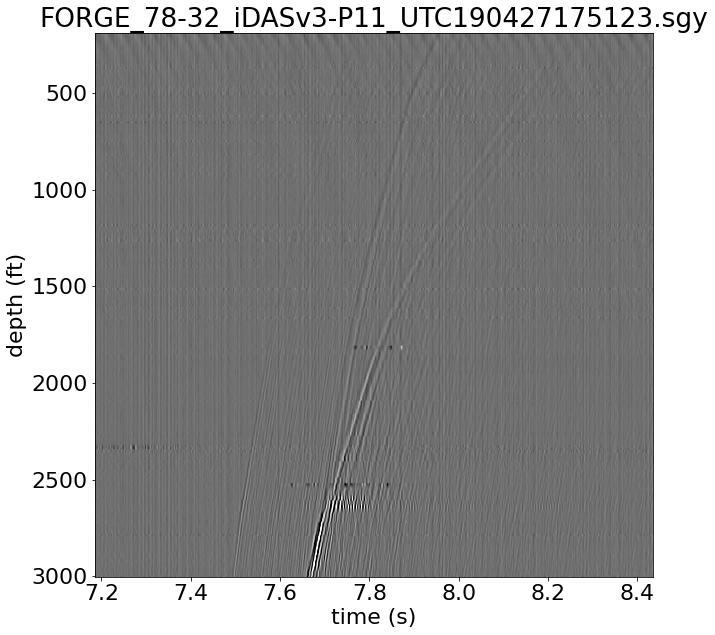

In [10]:
data, mask = client.line(event_34)
plot(data, time=client.time_seconds, depth=client.depth, 
            crop=(250, 1100, time_slice - 1000, time_slice + 1500), 
                title=client.segy_filenames[event_34],
                    cmap='gray', figsize=(10,10))                        


You'll notice that energy from a microseismic moves along a hyperbola as it arrives at each station in the vertical well, this is signal. Anything whose appearance is apparently instantaneous is essentially noise in this context. We can try to remove noise, there's a fairly average "process" command provided, to help see the events more clearly.

This function is slow and not calibrated in any systematic way, that's something to improve.

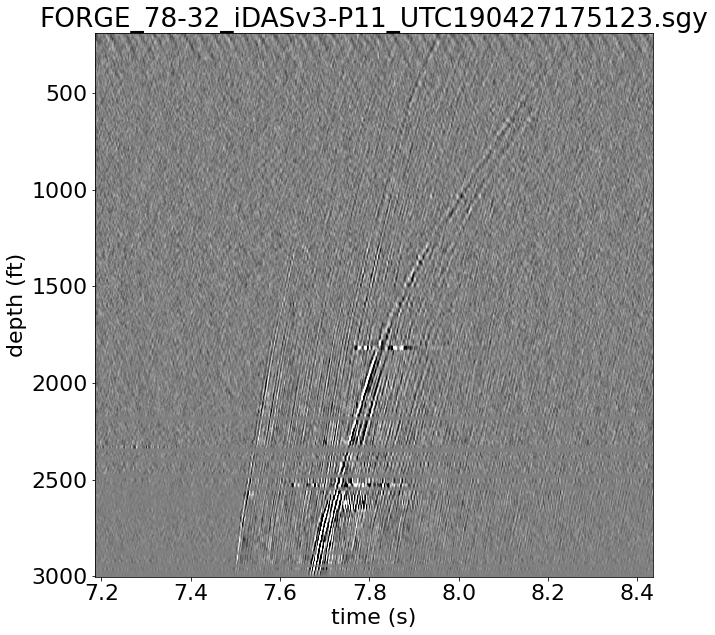

In [11]:
plot(process(data), time=client.time_seconds, depth=client.depth, 
            crop=(250, 1100, time_slice - 1000, time_slice + 1500), 
                title=client.segy_filenames[event_34],
                    cmap='gray', figsize=(10,10))